In [185]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
import warnings
warnings.filterwarnings("ignore")

In [186]:
%matplotlib inline

In [338]:
df = pd.read_csv('dataset-0510/train.csv')

In [324]:
df.head()

,building_id,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,...,XIV_500,XIV_index_500,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN,total_price
0,e3mMIMR3JJqCaXz1,8,21,18674,4,3,2,6271,2,NaN,...,58,1,157,1,2483,1,6011,1,34.469803,6.476038e+05
1,LgwzgklNvy4QCtq5,8,7,18800,5,1,2,7885,2,NaN,...,28,1,115,1,15872,1,32221,1,40.073573,3.321452e+06
2,ucIR2NLLsC3T650L,8,7,19289,4,1,2,6028,2,NaN,...,78,1,212,1,15760,1,32228,1,54.462081,9.570885e+06
3,jre1pJhcQj91Kdky,8,21,20385,24,0,2,18325,0,NaN,...,20,1,125,1,2568,1,7271,1,99.628966,1.421501e+07
4,rQpYpY9nRG7X5mmr,1,21,20657,2,4,2,6880,2,NaN,...,18,1,47,1,2587,1,7442,1,124.131236,7.627120e+05


## Check for missing data

In [189]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False)

In [190]:
missing_data = pd.concat([total, percent], keys=['Total', 'Percent'], axis = 1)

總共有 4 個 column 有 missing data
- parking_area 和 parking_price 缺太多資料補不了只好刪了
- 看一下 txn_floor 和 village_income_median 能不能捕

In [191]:
missing_data.head()

,Total,Percent
parking_area,56897,0.948283
parking_price,46065,0.767750
txn_floor,15902,0.265033
village_income_median,1142,0.019033
total_price,0,0.000000


In [325]:
df_txn_floor_notnull = df[df['txn_floor'].notnull()]
df_village_income_median_notnull = df[df['village_income_median'].notnull()]

畫出交易樓層跟平均價格的關係
- 看似好像有點關聯

,total_price,txn_floor
total_price,1.000000,0.046155
txn_floor,0.046155,1.000000


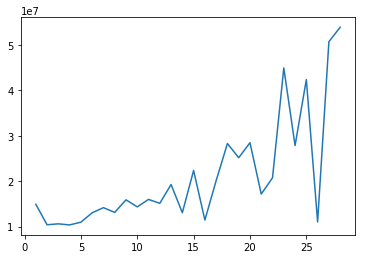

In [193]:
plt.plot(df_txn_floor_notnull.groupby(['txn_floor'])['total_price'].mean())
df_txn_floor_notnull[['total_price','txn_floor']].corr()

In [339]:
df['txn_floor'].fillna(df['total_floor'] // 2, inplace=True)

In [345]:
df['txn_floor'] = df['txn_floor'].astype('int64')

但發現大部分的數據其實是集中在 1- 7 樓，而上面的關係圖在 1 - 7 樓並沒有明確的關係，所以果斷捨棄這個 column

接下來看一下 village_income_median 能否補值

count    58858.000000
mean       674.840175
std        140.653083
min        411.000000
25%        583.000000
50%        642.000000
75%        729.000000
max       1851.000000
Name: village_income_median, dtype: float64


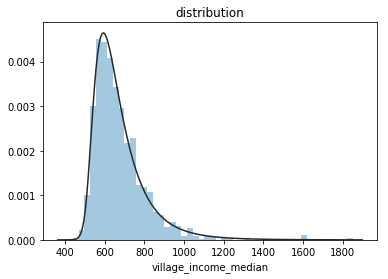

In [194]:
# plt.plot(df_txn_floor_notnull.groupby(['village_income_median'])['total_price'].mean())
print(df_village_income_median_notnull['village_income_median'].describe())
df_village_income_median_notnull[['total_price','village_income_median']].corr()
y = df_village_income_median_notnull['village_income_median']
plt.figure(1); plt.title('distribution')
sns.distplot(y, kde=False, fit=sp.stats.johnsonsu)

決定用同個 town 的 village_income_median 來填空值

In [340]:
s = df.groupby('town')['village_income_median'].median()
df['village_income_median'].fillna(df['town'].map(s), inplace=True)

In [341]:
df['village_income_median'].fillna(df['village_income_median'].mean(),inplace=True)

In [342]:
df.drop(['parking_area','parking_price'],axis=1,inplace=True)

有些 column 裡面只有一種 value，代表大家都有相同的資料

In [332]:
one_value_column = [i for i in df.columns if len(df[i].unique()) < 2]

In [333]:
df.drop(one_value_column,axis=1,inplace=True)

- 到此為止 df 所做的修改就只有把一些沒用的 column 丟掉跟補一些缺值

# 資料處理

- 先把名稱中含有 index 的 column 找出來，他們都是 categorical data
- 再手動把一些 categorical data 標出來
- categorical data: 共 54 個 (不包括 town 跟 village 因為他們種類太多了)
- numerical data: 共 156 個 (全部的 col 減掉 categorical data)

In [351]:
categorical = []

In [352]:
cat = ['total_floor','building_material',
       'city','building_type','txn_floor',
       'building_use','parking_way']

In [353]:
categorical = cat + categorical

In [354]:
numerical = [i for i in df.columns if i not in categorical]

- 把不同種類區分出來之後下一步就是要 get_dummy
- 但為了要一次轉換好必須先把類別資料 type 轉成 str

In [355]:
for col in categorical:
    df[col] = df[col].astype(str)

In [356]:
df_dummy = pd.get_dummies(df[categorical])
df_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 96 columns):
total_floor_1           60000 non-null uint8
total_floor_10          60000 non-null uint8
total_floor_11          60000 non-null uint8
total_floor_12          60000 non-null uint8
total_floor_13          60000 non-null uint8
total_floor_14          60000 non-null uint8
total_floor_15          60000 non-null uint8
total_floor_16          60000 non-null uint8
total_floor_17          60000 non-null uint8
total_floor_18          60000 non-null uint8
total_floor_19          60000 non-null uint8
total_floor_2           60000 non-null uint8
total_floor_20          60000 non-null uint8
total_floor_21          60000 non-null uint8
total_floor_22          60000 non-null uint8
total_floor_23          60000 non-null uint8
total_floor_24          60000 non-null uint8
total_floor_25          60000 non-null uint8
total_floor_26          60000 non-null uint8
total_floor_27          60000 non-nu

- 接著把轉換好的 dataframe 跟 numerical 的 dataframe 合併

In [357]:
df_after = pd.concat([df[numerical],df_dummy], axis=1) 

- 把剛剛那些步驟寫成 function 為了給之後的 testing data 使用

In [358]:
def dummy_transform(df):
    categorical = []
    cat = ['total_floor','building_material',
       'city','building_type','txn_floor',
       'building_use','parking_way']
    categorical = cat + categorical
    numerical = [i for i in df.columns if i not in categorical]
    for col in categorical:
        df[col] = df[col].astype(str)
    df_dummy = pd.get_dummies(df[categorical])
    return pd.concat([df[numerical],df_dummy], axis=1) 

- load testing data 進來

In [365]:
test = pd.read_csv('dataset-0510/test.csv')

In [367]:
#fill_val = test['village_income_median'].mode()[0]  # 634
#test['village_income_median'] = test['village_income_median'].fillna(fill_val)
s = test.groupby('town')['village_income_median'].median()
test['village_income_median'].fillna(test['town'].map(s), inplace=True)
test['village_income_median'].fillna(test['village_income_median'].mean(),inplace=True)
test['txn_floor'].fillna(test['total_floor'] // 2, inplace=True)
test['txn_floor'] = test['txn_floor'].astype('int64')

In [368]:
df.columns

Index(['building_id', 'building_material', 'city', 'txn_dt', 'total_floor',
       'building_type', 'building_use', 'building_complete_dt', 'parking_way',
       'txn_floor',
       ...
       'XIV_500', 'XIV_index_500', 'XIV_1000', 'XIV_index_1000', 'XIV_5000',
       'XIV_index_5000', 'XIV_10000', 'XIV_index_10000', 'XIV_MIN',
       'total_price'],
      dtype='object', length=233)

In [371]:
test = test[df.columns[:-1]]
test = dummy_transform(test)

In [372]:
test.info(verbose=True,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 319 columns):
building_id                10000 non-null object
txn_dt                     10000 non-null int64
building_complete_dt       10000 non-null int64
land_area                  10000 non-null float64
building_area              10000 non-null float64
town                       10000 non-null int64
lat                        10000 non-null float64
lon                        10000 non-null float64
village_income_median      10000 non-null float64
town_population            10000 non-null float64
town_area                  10000 non-null float64
town_population_density    10000 non-null float64
doc_rate                   10000 non-null float64
master_rate                10000 non-null float64
bachelor_rate              10000 non-null float64
jobschool_rate             10000 non-null float64
highschool_rate            10000 non-null float64
junior_rate                10000 non-null float6

- 發現 training data 裡面有些 column 在 testing data 裡面沒有
    - XI_index_10000_0
    - building_material_5

In [373]:
set(df_after.columns) - set(test.columns)

{'building_material_5', 'total_price', 'txn_floor_28'}

In [374]:
test['building_material_5'] = 0
test['txn_floor_28'] = 0

# 產生要訓練 model 的資料

In [122]:
df_after["total_price"].head()

0    6.476038e+05
1    3.321452e+06
2    9.570885e+06
3    1.421501e+07
4    7.627120e+05
Name: total_price, dtype: float64

In [123]:
np.floor(np.expm1(y))[:5]

0      647603.0
1     3321451.0
2     9570885.0
3    14215011.0
4      762711.0
Name: total_price, dtype: float64

In [375]:
y = np.log1p(df_after["total_price"])

In [376]:
X = df_after.drop(['building_id','total_price'],axis=1)

In [377]:
X_valid = X[50000:]
y_valid = y[50000:]
X = X[:50000]
y = y[:50000]

In [378]:
X_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 50000 to 59999
Columns: 320 entries, txn_dt to parking_way_2
dtypes: float64(33), int64(191), uint8(96)
memory usage: 18.0 MB


# Training

In [142]:
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

from mlxtend.regressor import StackingCVRegressor

from xgboost import XGBRegressor
from xgboost import plot_importance

In [130]:
def validation(prediction, ground_true):
    ground_true = np.floor(np.expm1(ground_true))
    ground_true = ground_true.reset_index(drop=True)
    
    prediction = np.floor(np.expm1(prediction))
    
    score = 0
    for i in range(len(prediction)):
        pred = prediction[i]
        roof = ground_true[i] + ground_true[i] / 10
        floor = ground_true[i] - ground_true[i] / 10
        if (pred <= roof) and (pred >= floor):
            score += 1
    return score

In [382]:
model = XGBRegressor(
    max_depth=8,
    n_estimators=5000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,  # Learning rate
    nthread=8,
    seed=41)

model.fit(
    X, 
    y, 
    eval_metric="rmse", 
    eval_set=[(X, y), (X_valid, y_valid)], 
    verbose=True, 
    early_stopping_rounds = 30)


[0]	validation_0-rmse:13.5616	validation_1-rmse:13.5563
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 30 rounds.
[1]	validation_0-rmse:12.2086	validation_1-rmse:12.2047
[2]	validation_0-rmse:10.9909	validation_1-rmse:10.9881
[3]	validation_0-rmse:9.89597	validation_1-rmse:9.89344
[4]	validation_0-rmse:8.91058	validation_1-rmse:8.90896
[5]	validation_0-rmse:8.02269	validation_1-rmse:8.02234
[6]	validation_0-rmse:7.22372	validation_1-rmse:7.2243
[7]	validation_0-rmse:6.50496	validation_1-rmse:6.50659
[8]	validation_0-rmse:5.85792	validation_1-rmse:5.86011
[9]	validation_0-rmse:5.27546	validation_1-rmse:5.27794
[10]	validation_0-rmse:4.75176	validation_1-rmse:4.75455
[11]	validation_0-rmse:4.2802	validation_1-rmse:4.2838
[12]	validation_0-rmse:3.85626	validation_1-rmse:3.86029
[13]	validation_0-rmse:3.475	validation_1-rmse:3.47916
[14]	validation_0-rmse:3.13193	validation_1-rmse:3.13614
[

[138]	validation_0-rmse:0.230741	validation_1-rmse:0.244362
[139]	validation_0-rmse:0.230371	validation_1-rmse:0.244058
[140]	validation_0-rmse:0.230036	validation_1-rmse:0.243868
[141]	validation_0-rmse:0.229956	validation_1-rmse:0.243822
[142]	validation_0-rmse:0.229734	validation_1-rmse:0.243665
[143]	validation_0-rmse:0.229423	validation_1-rmse:0.24342
[144]	validation_0-rmse:0.229292	validation_1-rmse:0.243332
[145]	validation_0-rmse:0.229058	validation_1-rmse:0.243197
[146]	validation_0-rmse:0.228907	validation_1-rmse:0.243064
[147]	validation_0-rmse:0.228606	validation_1-rmse:0.242834
[148]	validation_0-rmse:0.228444	validation_1-rmse:0.242714
[149]	validation_0-rmse:0.22834	validation_1-rmse:0.242681
[150]	validation_0-rmse:0.228244	validation_1-rmse:0.242687
[151]	validation_0-rmse:0.228053	validation_1-rmse:0.242521
[152]	validation_0-rmse:0.227774	validation_1-rmse:0.242324
[153]	validation_0-rmse:0.227619	validation_1-rmse:0.24227
[154]	validation_0-rmse:0.227523	validation

[275]	validation_0-rmse:0.209182	validation_1-rmse:0.231877
[276]	validation_0-rmse:0.20911	validation_1-rmse:0.231864
[277]	validation_0-rmse:0.208993	validation_1-rmse:0.231815
[278]	validation_0-rmse:0.208951	validation_1-rmse:0.231794
[279]	validation_0-rmse:0.208879	validation_1-rmse:0.231749
[280]	validation_0-rmse:0.208795	validation_1-rmse:0.231734
[281]	validation_0-rmse:0.208719	validation_1-rmse:0.23171
[282]	validation_0-rmse:0.208583	validation_1-rmse:0.231657
[283]	validation_0-rmse:0.20849	validation_1-rmse:0.231641
[284]	validation_0-rmse:0.20844	validation_1-rmse:0.231637
[285]	validation_0-rmse:0.208396	validation_1-rmse:0.231621
[286]	validation_0-rmse:0.208289	validation_1-rmse:0.231569
[287]	validation_0-rmse:0.208086	validation_1-rmse:0.231508
[288]	validation_0-rmse:0.208017	validation_1-rmse:0.231473
[289]	validation_0-rmse:0.207865	validation_1-rmse:0.231415
[290]	validation_0-rmse:0.207829	validation_1-rmse:0.231405
[291]	validation_0-rmse:0.207786	validation_

[412]	validation_0-rmse:0.197134	validation_1-rmse:0.226757
[413]	validation_0-rmse:0.19708	validation_1-rmse:0.226737
[414]	validation_0-rmse:0.197056	validation_1-rmse:0.226717
[415]	validation_0-rmse:0.196928	validation_1-rmse:0.22666
[416]	validation_0-rmse:0.196873	validation_1-rmse:0.226605
[417]	validation_0-rmse:0.196821	validation_1-rmse:0.226623
[418]	validation_0-rmse:0.196786	validation_1-rmse:0.226602
[419]	validation_0-rmse:0.196647	validation_1-rmse:0.226535
[420]	validation_0-rmse:0.196601	validation_1-rmse:0.226536
[421]	validation_0-rmse:0.196562	validation_1-rmse:0.226529
[422]	validation_0-rmse:0.196453	validation_1-rmse:0.226502
[423]	validation_0-rmse:0.196413	validation_1-rmse:0.22648
[424]	validation_0-rmse:0.19636	validation_1-rmse:0.226466
[425]	validation_0-rmse:0.196344	validation_1-rmse:0.226425
[426]	validation_0-rmse:0.196283	validation_1-rmse:0.226374
[427]	validation_0-rmse:0.196248	validation_1-rmse:0.226358
[428]	validation_0-rmse:0.196176	validation_

[550]	validation_0-rmse:0.186871	validation_1-rmse:0.222893
[551]	validation_0-rmse:0.186855	validation_1-rmse:0.222892
[552]	validation_0-rmse:0.186806	validation_1-rmse:0.222876
[553]	validation_0-rmse:0.186739	validation_1-rmse:0.222856
[554]	validation_0-rmse:0.186679	validation_1-rmse:0.222833
[555]	validation_0-rmse:0.186661	validation_1-rmse:0.222814
[556]	validation_0-rmse:0.186617	validation_1-rmse:0.222792
[557]	validation_0-rmse:0.186532	validation_1-rmse:0.222773
[558]	validation_0-rmse:0.186447	validation_1-rmse:0.222743
[559]	validation_0-rmse:0.186379	validation_1-rmse:0.222721
[560]	validation_0-rmse:0.186242	validation_1-rmse:0.222668
[561]	validation_0-rmse:0.186182	validation_1-rmse:0.222659
[562]	validation_0-rmse:0.186134	validation_1-rmse:0.222641
[563]	validation_0-rmse:0.186054	validation_1-rmse:0.222605
[564]	validation_0-rmse:0.186018	validation_1-rmse:0.222574
[565]	validation_0-rmse:0.185959	validation_1-rmse:0.222548
[566]	validation_0-rmse:0.185904	validat

[687]	validation_0-rmse:0.179289	validation_1-rmse:0.220572
[688]	validation_0-rmse:0.179268	validation_1-rmse:0.220564
[689]	validation_0-rmse:0.179193	validation_1-rmse:0.220554
[690]	validation_0-rmse:0.179159	validation_1-rmse:0.220531
[691]	validation_0-rmse:0.179079	validation_1-rmse:0.220498
[692]	validation_0-rmse:0.179004	validation_1-rmse:0.220475
[693]	validation_0-rmse:0.178984	validation_1-rmse:0.220475
[694]	validation_0-rmse:0.178861	validation_1-rmse:0.220453
[695]	validation_0-rmse:0.178813	validation_1-rmse:0.220446
[696]	validation_0-rmse:0.17875	validation_1-rmse:0.220395
[697]	validation_0-rmse:0.178716	validation_1-rmse:0.220404
[698]	validation_0-rmse:0.178699	validation_1-rmse:0.2204
[699]	validation_0-rmse:0.178642	validation_1-rmse:0.220394
[700]	validation_0-rmse:0.178604	validation_1-rmse:0.220377
[701]	validation_0-rmse:0.178521	validation_1-rmse:0.220377
[702]	validation_0-rmse:0.178426	validation_1-rmse:0.220367
[703]	validation_0-rmse:0.178362	validation

[824]	validation_0-rmse:0.172458	validation_1-rmse:0.218729
[825]	validation_0-rmse:0.172415	validation_1-rmse:0.218712
[826]	validation_0-rmse:0.172348	validation_1-rmse:0.218661
[827]	validation_0-rmse:0.172332	validation_1-rmse:0.218653
[828]	validation_0-rmse:0.172264	validation_1-rmse:0.218592
[829]	validation_0-rmse:0.172245	validation_1-rmse:0.218582
[830]	validation_0-rmse:0.172189	validation_1-rmse:0.218582
[831]	validation_0-rmse:0.172156	validation_1-rmse:0.218579
[832]	validation_0-rmse:0.172141	validation_1-rmse:0.218579
[833]	validation_0-rmse:0.172069	validation_1-rmse:0.218551
[834]	validation_0-rmse:0.171984	validation_1-rmse:0.218565
[835]	validation_0-rmse:0.171956	validation_1-rmse:0.218544
[836]	validation_0-rmse:0.171864	validation_1-rmse:0.218504
[837]	validation_0-rmse:0.171741	validation_1-rmse:0.218457
[838]	validation_0-rmse:0.171725	validation_1-rmse:0.21845
[839]	validation_0-rmse:0.171697	validation_1-rmse:0.21846
[840]	validation_0-rmse:0.171616	validatio

[962]	validation_0-rmse:0.165795	validation_1-rmse:0.21728
[963]	validation_0-rmse:0.165736	validation_1-rmse:0.217239
[964]	validation_0-rmse:0.165673	validation_1-rmse:0.217233
[965]	validation_0-rmse:0.165618	validation_1-rmse:0.217236
[966]	validation_0-rmse:0.1656	validation_1-rmse:0.217246
[967]	validation_0-rmse:0.165547	validation_1-rmse:0.217227
[968]	validation_0-rmse:0.165474	validation_1-rmse:0.217189
[969]	validation_0-rmse:0.165451	validation_1-rmse:0.217191
[970]	validation_0-rmse:0.165393	validation_1-rmse:0.217186
[971]	validation_0-rmse:0.165347	validation_1-rmse:0.217195
[972]	validation_0-rmse:0.165318	validation_1-rmse:0.217201
[973]	validation_0-rmse:0.165217	validation_1-rmse:0.217168
[974]	validation_0-rmse:0.165175	validation_1-rmse:0.217158
[975]	validation_0-rmse:0.165096	validation_1-rmse:0.217172
[976]	validation_0-rmse:0.16507	validation_1-rmse:0.217142
[977]	validation_0-rmse:0.16505	validation_1-rmse:0.217155
[978]	validation_0-rmse:0.165	validation_1-rm

[1098]	validation_0-rmse:0.160003	validation_1-rmse:0.216189
[1099]	validation_0-rmse:0.159956	validation_1-rmse:0.216182
[1100]	validation_0-rmse:0.159908	validation_1-rmse:0.216167
[1101]	validation_0-rmse:0.159896	validation_1-rmse:0.216165
[1102]	validation_0-rmse:0.15985	validation_1-rmse:0.21613
[1103]	validation_0-rmse:0.159784	validation_1-rmse:0.216096
[1104]	validation_0-rmse:0.159745	validation_1-rmse:0.216073
[1105]	validation_0-rmse:0.159737	validation_1-rmse:0.216064
[1106]	validation_0-rmse:0.159709	validation_1-rmse:0.21607
[1107]	validation_0-rmse:0.159654	validation_1-rmse:0.216036
[1108]	validation_0-rmse:0.15963	validation_1-rmse:0.216023
[1109]	validation_0-rmse:0.159589	validation_1-rmse:0.215994
[1110]	validation_0-rmse:0.159509	validation_1-rmse:0.215997
[1111]	validation_0-rmse:0.159468	validation_1-rmse:0.215981
[1112]	validation_0-rmse:0.159424	validation_1-rmse:0.215991
[1113]	validation_0-rmse:0.159402	validation_1-rmse:0.215986
[1114]	validation_0-rmse:0.1

[1233]	validation_0-rmse:0.1549	validation_1-rmse:0.214951
[1234]	validation_0-rmse:0.154843	validation_1-rmse:0.214934
[1235]	validation_0-rmse:0.15482	validation_1-rmse:0.214918
[1236]	validation_0-rmse:0.154771	validation_1-rmse:0.214909
[1237]	validation_0-rmse:0.154742	validation_1-rmse:0.214889
[1238]	validation_0-rmse:0.154703	validation_1-rmse:0.214876
[1239]	validation_0-rmse:0.154662	validation_1-rmse:0.214857
[1240]	validation_0-rmse:0.154637	validation_1-rmse:0.214856
[1241]	validation_0-rmse:0.154615	validation_1-rmse:0.214865
[1242]	validation_0-rmse:0.154568	validation_1-rmse:0.214852
[1243]	validation_0-rmse:0.154543	validation_1-rmse:0.214843
[1244]	validation_0-rmse:0.154521	validation_1-rmse:0.21483
[1245]	validation_0-rmse:0.15448	validation_1-rmse:0.214826
[1246]	validation_0-rmse:0.154409	validation_1-rmse:0.214814
[1247]	validation_0-rmse:0.154338	validation_1-rmse:0.214801
[1248]	validation_0-rmse:0.154289	validation_1-rmse:0.214814
[1249]	validation_0-rmse:0.15

[1368]	validation_0-rmse:0.150126	validation_1-rmse:0.214011
[1369]	validation_0-rmse:0.150081	validation_1-rmse:0.214012
[1370]	validation_0-rmse:0.150016	validation_1-rmse:0.214013
[1371]	validation_0-rmse:0.149972	validation_1-rmse:0.213989
[1372]	validation_0-rmse:0.149874	validation_1-rmse:0.213955
[1373]	validation_0-rmse:0.149809	validation_1-rmse:0.21396
[1374]	validation_0-rmse:0.149776	validation_1-rmse:0.213948
[1375]	validation_0-rmse:0.149725	validation_1-rmse:0.213934
[1376]	validation_0-rmse:0.149677	validation_1-rmse:0.213924
[1377]	validation_0-rmse:0.149583	validation_1-rmse:0.213914
[1378]	validation_0-rmse:0.149532	validation_1-rmse:0.213919
[1379]	validation_0-rmse:0.149494	validation_1-rmse:0.213934
[1380]	validation_0-rmse:0.14946	validation_1-rmse:0.213929
[1381]	validation_0-rmse:0.149419	validation_1-rmse:0.213932
[1382]	validation_0-rmse:0.14937	validation_1-rmse:0.213912
[1383]	validation_0-rmse:0.149319	validation_1-rmse:0.213911
[1384]	validation_0-rmse:0.

[1503]	validation_0-rmse:0.14504	validation_1-rmse:0.213103
[1504]	validation_0-rmse:0.145033	validation_1-rmse:0.213105
[1505]	validation_0-rmse:0.14496	validation_1-rmse:0.21306
[1506]	validation_0-rmse:0.144912	validation_1-rmse:0.213043
[1507]	validation_0-rmse:0.144864	validation_1-rmse:0.213028
[1508]	validation_0-rmse:0.14483	validation_1-rmse:0.213033
[1509]	validation_0-rmse:0.144797	validation_1-rmse:0.213004
[1510]	validation_0-rmse:0.14477	validation_1-rmse:0.213
[1511]	validation_0-rmse:0.144741	validation_1-rmse:0.212989
[1512]	validation_0-rmse:0.14469	validation_1-rmse:0.212988
[1513]	validation_0-rmse:0.144642	validation_1-rmse:0.212985
[1514]	validation_0-rmse:0.144626	validation_1-rmse:0.212968
[1515]	validation_0-rmse:0.144614	validation_1-rmse:0.212964
[1516]	validation_0-rmse:0.14458	validation_1-rmse:0.212949
[1517]	validation_0-rmse:0.144544	validation_1-rmse:0.212948
[1518]	validation_0-rmse:0.144522	validation_1-rmse:0.21294
[1519]	validation_0-rmse:0.144459	v

[1638]	validation_0-rmse:0.14025	validation_1-rmse:0.212236
[1639]	validation_0-rmse:0.140243	validation_1-rmse:0.212236
[1640]	validation_0-rmse:0.14022	validation_1-rmse:0.212252
[1641]	validation_0-rmse:0.140186	validation_1-rmse:0.212249
[1642]	validation_0-rmse:0.140115	validation_1-rmse:0.212245
[1643]	validation_0-rmse:0.140055	validation_1-rmse:0.212256
[1644]	validation_0-rmse:0.139999	validation_1-rmse:0.212227
[1645]	validation_0-rmse:0.13996	validation_1-rmse:0.21224
[1646]	validation_0-rmse:0.139928	validation_1-rmse:0.212246
[1647]	validation_0-rmse:0.13992	validation_1-rmse:0.212252
[1648]	validation_0-rmse:0.1399	validation_1-rmse:0.212258
[1649]	validation_0-rmse:0.139874	validation_1-rmse:0.212263
[1650]	validation_0-rmse:0.139826	validation_1-rmse:0.212253
[1651]	validation_0-rmse:0.139792	validation_1-rmse:0.212244
[1652]	validation_0-rmse:0.139763	validation_1-rmse:0.212249
[1653]	validation_0-rmse:0.139692	validation_1-rmse:0.212233
[1654]	validation_0-rmse:0.1396

[1773]	validation_0-rmse:0.136091	validation_1-rmse:0.211725
[1774]	validation_0-rmse:0.136076	validation_1-rmse:0.211715
[1775]	validation_0-rmse:0.136044	validation_1-rmse:0.211719
[1776]	validation_0-rmse:0.136027	validation_1-rmse:0.211736
[1777]	validation_0-rmse:0.136013	validation_1-rmse:0.21173
[1778]	validation_0-rmse:0.13599	validation_1-rmse:0.211742
[1779]	validation_0-rmse:0.135987	validation_1-rmse:0.211741
[1780]	validation_0-rmse:0.135965	validation_1-rmse:0.211744
[1781]	validation_0-rmse:0.135937	validation_1-rmse:0.211735
[1782]	validation_0-rmse:0.135904	validation_1-rmse:0.211702
[1783]	validation_0-rmse:0.135845	validation_1-rmse:0.211697
[1784]	validation_0-rmse:0.13584	validation_1-rmse:0.211702
[1785]	validation_0-rmse:0.135832	validation_1-rmse:0.2117
[1786]	validation_0-rmse:0.135791	validation_1-rmse:0.211684
[1787]	validation_0-rmse:0.135753	validation_1-rmse:0.211676
[1788]	validation_0-rmse:0.135716	validation_1-rmse:0.211674
[1789]	validation_0-rmse:0.13

[1908]	validation_0-rmse:0.132107	validation_1-rmse:0.211121
[1909]	validation_0-rmse:0.132076	validation_1-rmse:0.211131
[1910]	validation_0-rmse:0.132062	validation_1-rmse:0.211124
[1911]	validation_0-rmse:0.132039	validation_1-rmse:0.211112
[1912]	validation_0-rmse:0.132031	validation_1-rmse:0.211115
[1913]	validation_0-rmse:0.132001	validation_1-rmse:0.211096
[1914]	validation_0-rmse:0.131964	validation_1-rmse:0.211096
[1915]	validation_0-rmse:0.131919	validation_1-rmse:0.211083
[1916]	validation_0-rmse:0.131877	validation_1-rmse:0.21108
[1917]	validation_0-rmse:0.131832	validation_1-rmse:0.211078
[1918]	validation_0-rmse:0.131823	validation_1-rmse:0.211082
[1919]	validation_0-rmse:0.131779	validation_1-rmse:0.211076
[1920]	validation_0-rmse:0.131752	validation_1-rmse:0.211072
[1921]	validation_0-rmse:0.131712	validation_1-rmse:0.211071
[1922]	validation_0-rmse:0.131689	validation_1-rmse:0.21106
[1923]	validation_0-rmse:0.131677	validation_1-rmse:0.211063
[1924]	validation_0-rmse:0

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eta=0.3, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=300, missing=None, n_estimators=5000, n_jobs=1,
       nthread=8, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=41, silent=True,
       subsample=0.8)

In [383]:
validation(model.predict(X_valid),y_valid)

4769

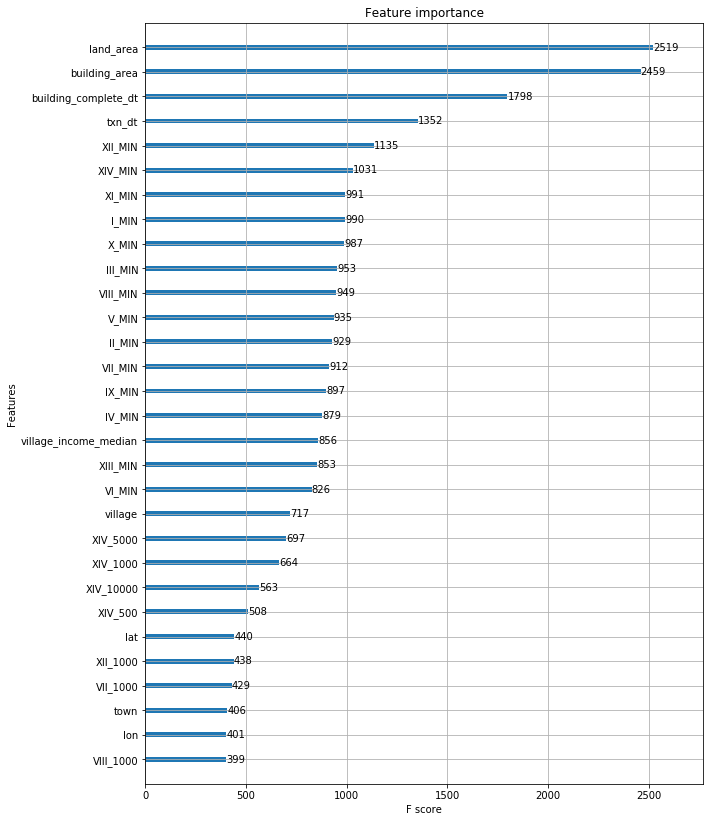

In [384]:
fig, ax = plt.subplots(1,1,figsize=(10,14))
plot_importance(booster=model, ax=ax, max_num_features=30)

In [385]:
test_ = test[X.columns]

In [386]:
pred = model.predict(test_)

In [387]:
pred_ = np.floor(np.expm1(pred))

In [388]:
test_id = test['building_id']

In [389]:
data = {'building_id':test_id, 'total_price':pred_}
sub = pd.DataFrame(data) 

In [390]:
sub.head()

,building_id,total_price
0,X5gsdTWGS3W7JJQB,10306023.0
1,BTshNOJyKHnT2YIT,3924241.0
2,dhdymr0lV8N5kZOT,10422298.0
3,VEwyGGMcD56w5BOc,6595294.0
4,wmUeMoJZfsqaSX9b,995721.0


In [391]:
sub.to_csv('sub_7.csv',index=False)

,building_id,txn_dt,building_complete_dt,land_area,building_area,town,lat,lon,village_income_median,town_population,...,building_use_3,building_use_4,building_use_5,building_use_6,building_use_7,building_use_8,parking_way_0,parking_way_1,parking_way_2,building_material_5


In [ ]:
te